In [3]:
from itertools import cycle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

import common

## Load the data and get some high level statistics

In [4]:
df = pd.read_csv('data/interim/final_paths_ordered.csv')
df

,Level 1,Level 2,Level 3,Level 4,Level 5,Level 6,Level 7,Relative Strength
0,______,A_____,AA____,AAT___,AATT__,AATTT_,AATTTA,0.1190
1,______,A_____,AA____,AAT___,AATT__,AATT_T,AATTCT,0.1175
2,______,A_____,AA____,AAT___,AAT_C_,AATTC_,AATTCA,0.1068
3,______,A_____,AA____,AA_T__,AA_TT_,AA_TTA,AACTTA,0.1186
4,______,A_____,AA____,AA__C_,AA__CC,AAA_CC,AAATCC,0.1145
...,...,...,...,...,...,...,...,...
4091,______,_____T,____TT,_C__TT,_C_GTT,_CAGTT,CCAGTT,0.0814
4092,______,_____T,____TT,__C_TT,G_C_TT,GCC_TT,GCCATT,0.1043
4093,______,_____T,____TT,__C_TT,G_C_TT,G_CTTT,GTCTTT,0.1011
4094,______,_____T,____TT,__C_TT,_CC_TT,CCC_TT,CCCATT,0.1098


In [5]:
# Count the number of rows where 'Level 1' contains certain nucleotide
countA = df[df['Level 2'].str.contains('A')].shape[0]
countG = df[df['Level 2'].str.contains('G')].shape[0]
countC = df[df['Level 2'].str.contains('C')].shape[0]
countT = df[df['Level 2'].str.contains('T')].shape[0]

print("Number of rows where 'Level 2' is 'A':", countA)
print("Number of rows where 'Level 2' is 'G':", countG)
print("Number of rows where 'Level 2' is 'C':", countC)
print("Number of rows where 'Level 2' is 'T':", countT)

Number of rows where 'Level 2' is 'A': 409
Number of rows where 'Level 2' is 'G': 2464
Number of rows where 'Level 2' is 'C': 573
Number of rows where 'Level 2' is 'T': 650


## Remove the Level 1 and (optionally) set some minimal threshold for the Relative Strength or other filters

In [6]:
THRESHOLD = 0.25
df = df.drop(columns=['Level 1'])
# df = df[df['Relative Strength'] >= THRESHOLD]

## One-hot encoding

### Encode the sequences

In [7]:
# Function to one-hot encode a single sequence
def one_hot_encode(sequence, characters):
    char_to_int = dict((c, i) for i, c in enumerate(characters))
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(characters))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded).flatten()

# Apply the encoding to each column in the dataframe and preserve column names
encoded_columns = []
for col in df.columns[:-1]:  # Exclude 'Relative Strength' column for encoding
    encoded_sequences = df[col].apply(lambda x: one_hot_encode(x, common.POSSIBLE_CHARACTERS))
    col_encoded_df = pd.DataFrame(encoded_sequences.tolist(), columns=[f"{col}_{i}" for i in range(encoded_sequences.iloc[0].size)])
    encoded_columns.append(col_encoded_df)

# Concatenate all encoded columns into a single dataframe
encoded_df = pd.concat(encoded_columns, axis=1)

### Encode the relative strength value

In [8]:
# Add index as a column for clustering
encoded_df['index'] = df.index
encoded_df['Relative Strength'] = df['Relative Strength']

# Encode the relative strength
NUMBER_OF_COLUMNS_FOR_STRENGTH = 200

# Function to convert a value to a binary list with 200 columns
def value_to_binary_list(value, length=NUMBER_OF_COLUMNS_FOR_STRENGTH):
    ones_count = int(round(value, 2) * NUMBER_OF_COLUMNS_FOR_STRENGTH)
    return [1] * ones_count + [0] * (length - ones_count)

# Apply the function to create binary columns
binary_columns = df['Relative Strength'].apply(value_to_binary_list)

# Create a DataFrame from the binary columns
binary_df = pd.DataFrame(binary_columns.tolist(), columns=[f'rel_strength_{i+1}' for i in range(NUMBER_OF_COLUMNS_FOR_STRENGTH)])

encoded_df = pd.concat([encoded_df, binary_df], axis=1)

encoded_df

,Level 2_0,Level 2_1,Level 2_2,Level 2_3,Level 2_4,Level 2_5,Level 2_6,Level 2_7,Level 2_8,Level 2_9,...,rel_strength_191,rel_strength_192,rel_strength_193,rel_strength_194,rel_strength_195,rel_strength_196,rel_strength_197,rel_strength_198,rel_strength_199,rel_strength_200
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4092,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4093,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4094,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## DBSCAN

In [9]:
# Perform DBSCAN
number_of_clusters = 1000
current_eps = 5.9

# current_eps = 0.1 # For mahalanobis

while number_of_clusters > 400:
    # db = DBSCAN(eps=current_eps, min_samples=1, metric='mahalanobis', metric_params={'VI':np.cov(encoded_df)}, algorithm='brute', leaf_size=30, n_jobs=-1)
    db = DBSCAN(eps=current_eps, min_samples=1, leaf_size=30, n_jobs=6)
    clusters = db.fit_predict(encoded_df)
    unique_clusters = set(clusters)
    number_of_clusters = len(unique_clusters)
    print(f'For eps = {current_eps}, the number of clusters is {len(unique_clusters)}')
    current_eps += 0.05

# Add cluster labels to the DataFrame
encoded_df['CLUSTER'] = clusters

C:\Users\Pavel\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Systém nemůže nalézt uvedený soubor
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Pavel\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Pavel\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pavel\miniconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Pavel\miniconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProc

For eps = 5.9, the number of clusters is 481
For eps = 5.95, the number of clusters is 442
For eps = 6.0, the number of clusters is 442
For eps = 6.05, the number of clusters is 419
For eps = 6.1, the number of clusters is 381


### Save the dataframe

In [10]:
encoded_df['SEQ'] = df['Level 7']
encoded_df['CORE REL EXPR'] = df['Relative Strength']
encoded_df.to_csv('data/interim/dbscan_clusters_df.csv', index=False)

### Visualization

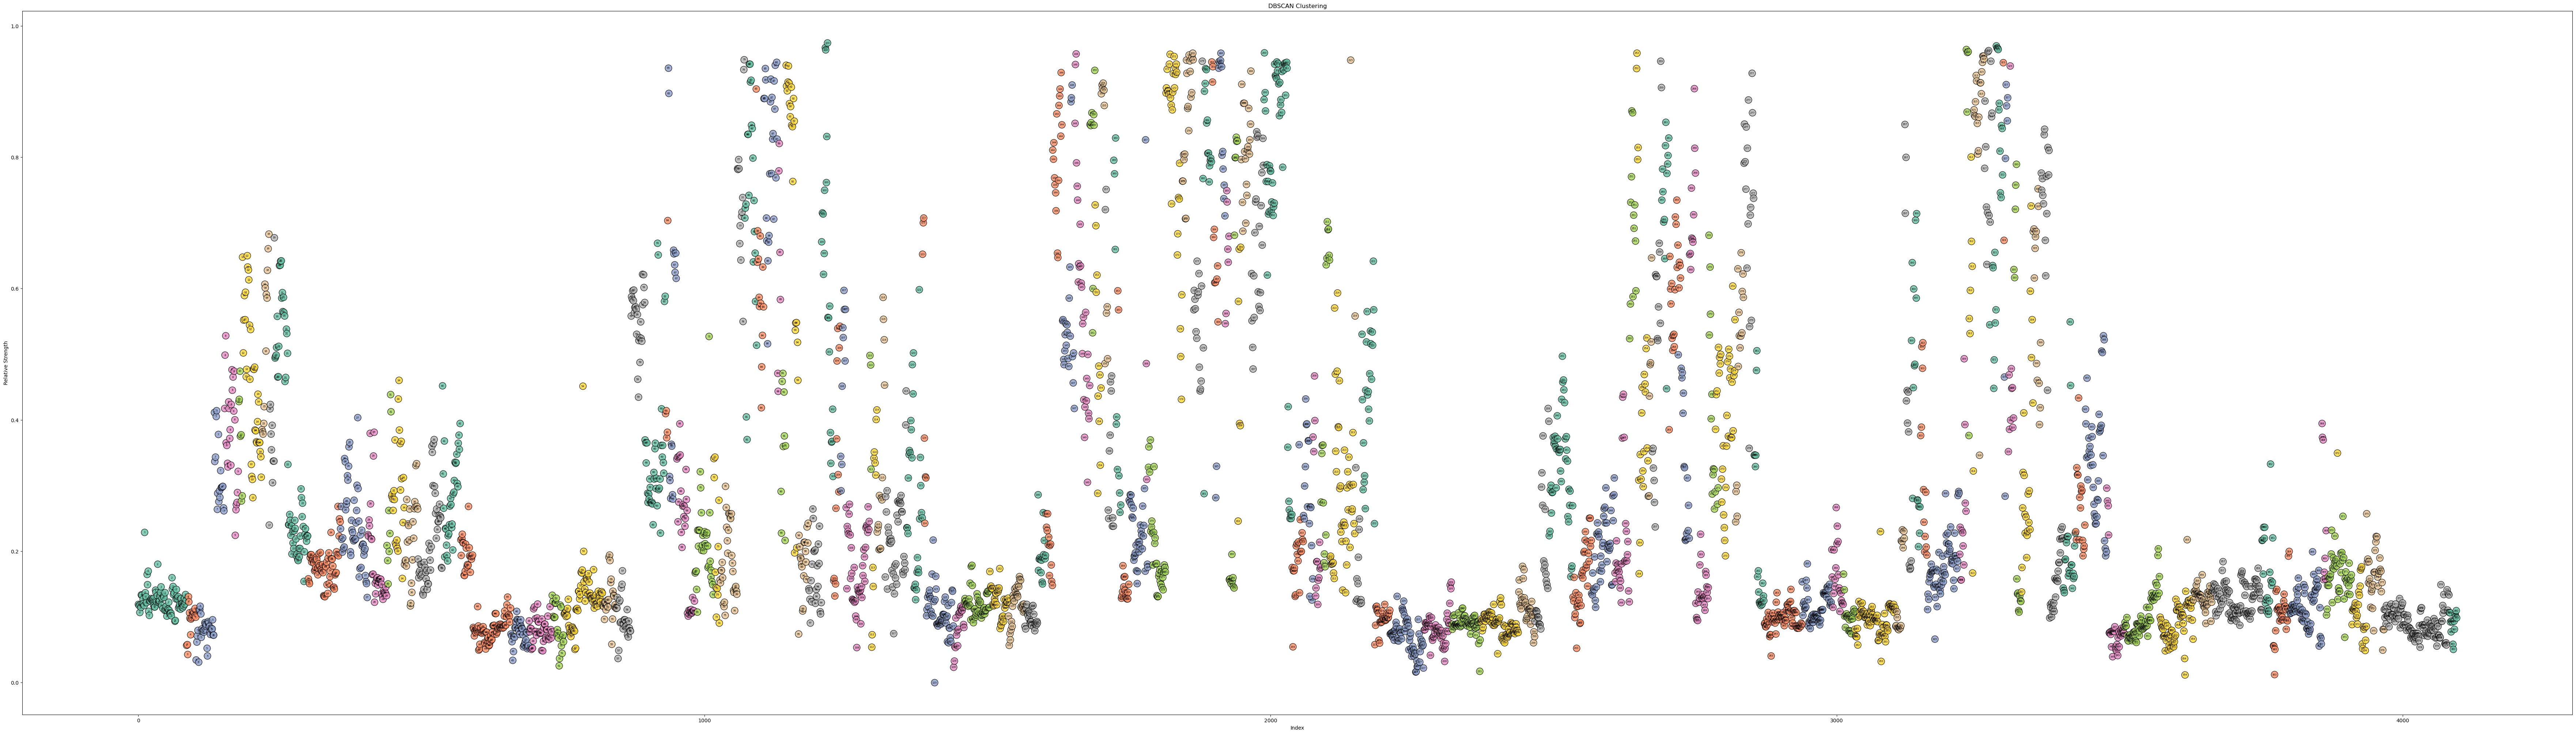

In [11]:
# Create a color cycle from a colormap
color_cycle = cycle(cm.Set2(np.linspace(0, 1, 20)))

# Map each unique cluster to a color
color_map = {cluster: next(color_cycle) for cluster in unique_clusters}

# Visualization
plt.figure(figsize=(90, 25))

for cluster in unique_clusters:
    color = color_map[cluster]
    cluster_mask = clusters == cluster
    plt.scatter(encoded_df.index[cluster_mask], encoded_df['Relative Strength'][cluster_mask], 
                color=color, label=f'Cluster {cluster}', s=180, edgecolor='k', alpha=0.8)
    # Add cluster number inside each circle
    for idx in encoded_df.index[cluster_mask]:
        plt.text(idx, encoded_df['Relative Strength'][idx], str(cluster), # str(idx), 
                 color='black', fontsize=5, ha='center', va='center')

# Highlight noise points (if any)
noise_mask = clusters == -1
plt.scatter(encoded_df.index[noise_mask], encoded_df['Relative Strength'][noise_mask], 
            color='red', label='Noise', s=180, marker='x')

plt.xlabel('Index')
plt.ylabel('Relative Strength')
plt.title('DBSCAN Clustering')

# Save the plot to a file
plt.savefig('dbscan_clustering_plot.png')

## Create a final dataframe with clusters their mean and CV

In [12]:
# From the encoded_df, use only columns 'CLUSTER', 'SEQ' and 'CORE REL EXPR'
df = encoded_df[['CLUSTER', 'SEQ', 'CORE REL EXPR']]

# Group by cluster, calculate the mean and std for each cluster and add all SEQs to the dataframe
df_grouped = df.groupby('CLUSTER').agg({'CORE REL EXPR': ['mean', 'std'], 'SEQ': 'unique'}).reset_index()
# Remove the line breaks from the header
df_grouped.columns = df_grouped.columns.map('_'.join)
# Remove the line breaks from the SEQ_unique values
df_grouped['SEQ_unique'] = df_grouped['SEQ_unique'].apply(lambda x: ','.join(x))
df_grouped

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,"AATTTA,AATTCT,AATTCA,AACTTA,AAATCC,AATATG,AATA..."
1,1,0.229000,NaN,ATCCGC
2,2,0.123416,0.014622,"ACCTAC,ACCTCC,ACATCC,ACATCA,ACATAC,AAATCA,ATAT..."
3,3,0.052767,0.008386,"CGTTCC,CGTCCC,CGTCAC"
4,4,0.104843,0.013261,"CCGAAA,CCGAAT,CCGTGA,CTGCCT,CCGGAC,CAAGTC,CCGG..."
...,...,...,...,...
376,376,0.070700,0.018187,"CATCCG,TCACCG,TCCCCG"
377,377,0.103400,0.011403,"ACTCGT,ACACCT,ACCTTT,ACATCT,CCCTAT,CCCCCT,CCAA..."
378,378,0.081756,0.017708,"ACCAGT,ACCCAT,ATCCCT,AACAAT,CCCAAT,TCCCAT,GCCC..."
379,379,0.130325,0.013597,"ACTAGT,CCAAGT,ATCAGT,CACAGT"


In [13]:
df_grouped.to_csv('data/processed/clusters_with_stats.csv', index=False)